In [19]:
from dataclasses import dataclass
import numpy as np
from scipy.integrate import quad, quad_vec
from scipy.special import jv
import xraydb 
from datetime import datetime
import matplotlib.pyplot as plt

############################################     CONSTANTS   #########################################################

# Fundamental constants
c = 3e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant in J/K
e = 1.6e-19  # Elementary charge in C
Na = 6.022e23  # Avogadro's number


############################################     FUNCTIONS   #########################################################


def calculate_sigma0(E0, Ie, Ig, alpha):
    return 2.446e-15 / (E0 / 1e3) ** 2 * (2 * Ie + 1) / (2 * Ig + 1) * 1 / (1 + alpha)

def calculate_mu_e(element, energy):
    return xraydb.mu_elam(element, energy)

def calculate_recoilless_fraction(T, Td, E0, M):
    integral = quad(lambda x: x / (np.exp(x) - 1), 0, Td / T)[0]
    return np.exp(-(3 * (E0 * e) ** 2) / (kB * Td * M * c ** 2) * (1 / 4 + (T / Td) ** 2 * integral))

def get_current_activity(half_life_days, activity, date, nowdate=None):
    if nowdate is None:
        nowdate = datetime.now()
    else:
        nowdate = datetime.strptime(nowdate, '%Y%m%d')
    tdiff_seconds = (nowdate - datetime.strptime(date, '%Y%m%d')).total_seconds()
    return activity*((0.5)**(tdiff_seconds/(3600*24)/half_life_days))


def calculate_photon_rate(activity_Ci,relative_intensity):
    return 3.7e10 * activity_Ci * relative_intensity

def calculate_thickness_gcm2(thickness_m, rho, abundance):
    return thickness_m * rho/10 * abundance

def _lorentzian_s(x, x0, gamma):
    return gamma/(2*np.pi)/( ((x-x0))**2 + (gamma/2)**2)

def _lorentzian_a(x, x0, gamma):
    return (gamma/2)**2/( ((x-x0))**2 + (gamma/2)**2)


############################################     SOURCE CLASSES   #########################################################
class CobaltRhodium:
    def __init__(self):
        self.T = 292
        self.Td = 510
        self.E0 = 14.4e3
        self.Gamma_ev = 4.55e-9
        self.Eres = [0]
        self.split_ratio = [1]
        self.activity_Ci = 50e-3
        self.production_date = '20250112'
        self.date = None
        self.half_life = 272
        self.mossbauer_relative_intensity = 0.0916
        self.M = 57e-3 / Na
        self.element = 'Fe'
        self.alpha = 8.17
        self.update_params()
    
    def update_params(self):
        self.Gamma = self.Gamma_ev * c / self.E0 * 1000
        self.current_activity_Ci = get_current_activity(self.half_life, self.activity_Ci, self.production_date, self.date)
        self.mossbauer_photon_rate = calculate_photon_rate(self.current_activity_Ci, self.mossbauer_relative_intensity)
        self.fs = calculate_recoilless_fraction(self.T, self.Td, self.E0, self.M)
        self.transition_coefficients = np.asarray(self.split_ratio, dtype=float) / np.sum(self.split_ratio)


class CobaltFe:
    def __init__(self):
        self.T = 292
        self.Td = 470
        self.E0 = 14.4e3
        self.Gamma_ev = 4.55e-9
        self.Eres = [-5, -3, -1, 1, 3, 5]
        self.split_ratio = [3, 2, 1, 1, 2, 3]
        self.activity_Ci = 50e-3
        self.production_date = '20250112'
        self.date = None
        self.half_life = 272
        self.mossbauer_relative_intensity = 0.0916
        self.M = 57e-3 / Na
        self.element = 'Fe'
        self.alpha = 8.17
        self.update_params()
    
    def update_params(self):
        self.Gamma = self.Gamma_ev * c / self.E0 * 1000
        self.current_activity_Ci = get_current_activity(self.half_life, self.activity_Ci, self.production_date, self.date)
        self.mossbauer_photon_rate = calculate_photon_rate(self.current_activity_Ci, self.mossbauer_relative_intensity)
        self.fs = calculate_recoilless_fraction(self.T, self.Td, self.E0, self.M)
        self.transition_coefficients = np.asarray(self.split_ratio, dtype=float) / np.sum(self.split_ratio)


############################################     ABSORBER CLASSES   #########################################################


class alphaFe:
    def __init__(self):
        self.thickness_m = 25e-6
        self.T = 292
        self.Td = 470
        self.E0 = 14.4e3
        self.Gamma_ev = 4.55e-9
        self.Eres = [-5, -3, -1, 1, 3, 5]
        self.split_ratio = [3, 2, 1, 1, 2, 3]
        self.abundance = 0.0212
        self.M = 57e-3 / Na
        self.nM = Na / 57
        self.rho = 7.87e3
        self.element = 'Fe'
        self.alpha = 8.17
        self.update_params()
    
    def update_params(self):
        self.Gamma = self.Gamma_ev * c / self.E0 * 1000
        self.mu_e = calculate_mu_e(self.element, self.E0)
        self.fa = calculate_recoilless_fraction(self.T, self.Td, self.E0, self.M)
        self.transition_coefficients = np.asarray(self.split_ratio, dtype=float) / np.sum(self.split_ratio)
        self.sigma0 = calculate_sigma0(self.E0, 3/2, 1/2, self.alpha)
        self.thickness_gcm2 = calculate_thickness_gcm2(self.thickness_m, self.rho, 1)
        self.thickness_gcm2_Fe57 = calculate_thickness_gcm2(self.thickness_m, self.rho, self.abundance)
        self.thickness_normalized = self.fa * self.nM * self.sigma0 * self.thickness_gcm2_Fe57


class KFeCy:
    def __init__(self):
        self.thickness_gcm2_Fe = 6e-3
        self.E0 = 14.4e3
        self.Gamma_ev = 4.55e-9
        self.Eres = [0]
        self.split_ratio = [1]
        self.abundance = 0.0212
        self.M = 57e-3 / Na
        self.nM = Na / 57
        self.rho = 7.87e3
        self.elements = {'Fe': 1, 'K': 4, 'C': 6, 'N': 6, 'H': 6, 'O': 3}
        self.alpha = 8.17
        self.sigma0 = 2.1e-18 # https://journals.aps.org/prb/pdf/10.1103/PhysRevB.4.2915
        self.fa = 0.311 # https://www.sciencedirect.com/science/article/abs/pii/0029554X81900987
        self.update_params()
    
    def update_params(self):
        self.Gamma = self.Gamma_ev * c / self.E0 * 1000
        self.transition_coefficients = np.asarray(self.split_ratio, dtype=float) / np.sum(self.split_ratio)
        self.thickness_gcm2_Fe57 = self.thickness_gcm2_Fe * self.abundance
        self.thickness_normalized = self.fa * self.nM * self.sigma0 * self.thickness_gcm2_Fe57
        self.mass_sum = np.sum([val * xraydb.atomic_mass(element) for element, val in self.elements.items()])
        self.mu_e = np.sum([xraydb.mu_elam(element, self.E0) * multiplicity * xraydb.atomic_mass(element) / self.mass_sum 
                            for element, multiplicity in self.elements.items()])
        self.thickness_gcm2 = self.thickness_gcm2_Fe / (self.elements['Fe'] * xraydb.atomic_mass('Fe')) * self.mass_sum

        
    
        
    
###########################################      MOSSBAUER    ######################################################

c=3e8

class Mossbauer:
    
    def __init__(self, source, absorber):
    
        self.source = source
        self.absorber = absorber

    def source_specrtrum(self, E, v):
        spectrum = 0
        for coef, Eres in zip(self.source.transition_coefficients, self.source.Eres):
                spectrum += coef *_lorentzian_s(
                    E,
                    Eres - v,
                    self.source.Gamma
                )
        
        return  self.source.mossbauer_photon_rate * self.source.fs  * spectrum
    
    def cross_section(self, E):
        spectrum = 0
        for coef, Eres in zip(self.absorber.transition_coefficients, self.absorber.Eres):
            spectrum += coef *_lorentzian_a(
                E,
                Eres,
                self.absorber.Gamma
            )
            
        return self.absorber.sigma0 * spectrum
    
    def non_resonant_attenuation(self):
        return np.exp(-self.absorber.mu_e * self.absorber.thickness_gcm2) 
    
    def resonant_transmission_fraction(self, E, v):
        
        res = ( self.source_specrtrum(E, v) 
                * np.exp(-self.cross_section(E) * self.absorber.fa * self.absorber.nM * self.absorber.thickness_gcm2_Fe57 )
                * self.non_resonant_attenuation()
              )
        return res
                         
    def reosnant_transmission_rate(self, v):
        res = quad_vec(lambda E: self.resonant_transmission_fraction(E,v), -np.inf, np.inf)[0]
        return res
    
    def nonresonant_transmission_rate(self):
        return self.source.mossbauer_photon_rate * (1 - self.source.fs) * self.non_resonant_attenuation()

    def total_transmission_rate1(self, v):
        return self.nonresonant_transmission_rate() + self.reosnant_transmission_rate(v)
 
    
    def epsilon(self,t):
        return 1-np.exp(-t/2)*jv(0,1j*t/2).real



(0.27465570257793753,
 0.2722116034187059,
 151.25333991759393,
 0.4123607978830409)

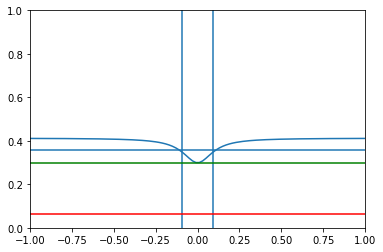

In [21]:
source = CobaltRhodium()

absorber = KFeCy()
absorber.update_params()

moss = Mossbauer(source, absorber)

v = np.linspace(-10,10,1000)
t = moss.total_transmission_rate1(v)
norm = moss.source.mossbauer_photon_rate


plt.plot(v, t/norm, label = 'Fe')

plt.axhline((1-((t.max()-t.min())/2/t.max()))*moss.non_resonant_attenuation())
plt.axvline(-(source.Gamma + absorber.Gamma)/2)
plt.axvline((source.Gamma + absorber.Gamma)/2)

plt.axhline((1 - source.fs)*moss.non_resonant_attenuation(),color = 'r')
plt.axhline((1 - source.fs*moss.epsilon(absorber.thickness_normalized))*moss.non_resonant_attenuation(),color = 'g')



plt.ylim(0,1)
plt.xlim(-1,1)


vis = moss.epsilon(absorber.thickness_normalized)*source.fs
vis, (t.max()-t.min())/t.max(), source.mossbauer_photon_rate/1e6, moss.non_resonant_attenuation()

(0.5739812057385447,
 0.48700104058491883,
 151.2533196972632,
 0.28477637176683074)

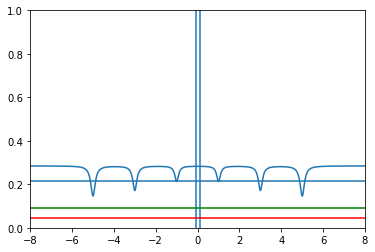

In [22]:
source = CobaltRhodium()
#source.update_params()
absorber = alphaFe()
absorber.thickness_m = 25e-6
absorber.abundance = 0.0212
absorber.update_params()

moss = Mossbauer(source, absorber)


v = np.linspace(-10,10,1000)
t = moss.total_transmission_rate1(v)
norm = moss.source.mossbauer_photon_rate


plt.plot(v, t/norm, label = 'Fe')

plt.axhline((1-((t.max()-t.min())/2/t.max()))*moss.non_resonant_attenuation())
plt.axvline(-(source.Gamma + absorber.Gamma)/2)
plt.axvline((source.Gamma + absorber.Gamma)/2)

plt.axhline((1 - source.fs)*moss.non_resonant_attenuation(),color = 'r')
plt.axhline((1 - source.fs*moss.epsilon(absorber.thickness_normalized))*moss.non_resonant_attenuation(),color = 'g')



plt.ylim(0,1)
plt.xlim(-8,8)


vis = moss.epsilon(absorber.thickness_normalized*3/12)
vis, (t.max()-t.min())/t.max(), source.mossbauer_photon_rate/1e6, moss.non_resonant_attenuation()

(0.6200655748807714,
 0.6180967411233926,
 151.25328078948164,
 0.9850404104576503)

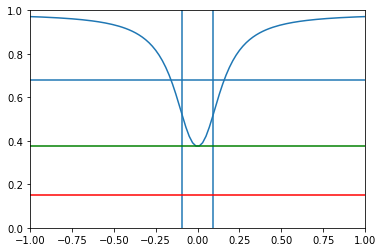

In [23]:
source = CobaltRhodium()
absorber = alphaFe()
absorber.thickness_m = 300e-9
absorber.Eres = [0]
absorber.split_ratio = [1]
absorber.abundance = 0.95
absorber.update_params()

moss = Mossbauer(source, absorber)

v = np.linspace(-10,10,1000)
t = moss.total_transmission_rate1(v)
norm = moss.source.mossbauer_photon_rate


plt.plot(v, t/norm, label = 'Fe')

plt.axhline((1-((t.max()-t.min())/2/t.max()))*moss.non_resonant_attenuation())
plt.axvline(-(source.Gamma + absorber.Gamma)/2)
plt.axvline((source.Gamma + absorber.Gamma)/2)

plt.axhline((1 - source.fs)*moss.non_resonant_attenuation(),color = 'r')
plt.axhline((1 - source.fs*moss.epsilon(absorber.thickness_normalized))*moss.non_resonant_attenuation(),color = 'g')


plt.ylim(0,1)
plt.xlim(-1,1)


vis = moss.epsilon(absorber.thickness_normalized)*source.fs
vis, (t.max()-t.min())/t.max(), source.mossbauer_photon_rate/1e6,moss.non_resonant_attenuation()

(0.6035227264452516,
 0.27823598117534126,
 151.25324870136942,
 0.9850404104576503)

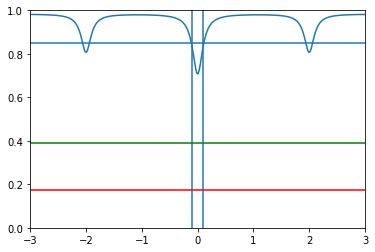

In [24]:
source = CobaltFe()
absorber = alphaFe()
absorber.thickness_m = 300e-9
absorber.abundance = 0.95
absorber.update_params()

moss = Mossbauer(source, absorber)

v = np.linspace(-10,10,1000)
t = moss.total_transmission_rate1(v)
norm = moss.source.mossbauer_photon_rate


plt.plot(v, t/norm, label = 'Fe')

plt.axhline((1-((t.max()-t.min())/2/t.max()))*moss.non_resonant_attenuation())
plt.axvline(-(source.Gamma + absorber.Gamma)/2)
plt.axvline((source.Gamma + absorber.Gamma)/2)

plt.axhline((1 - source.fs)*moss.non_resonant_attenuation(),color = 'r')
plt.axhline((1 - source.fs*moss.epsilon(absorber.thickness_normalized))*moss.non_resonant_attenuation(),color = 'g')


plt.ylim(0,1)
plt.xlim(-3,3)

vis = moss.epsilon(absorber.thickness_normalized)*source.fs
vis, (t.max()-t.min())/t.max(), source.mossbauer_photon_rate/1e6,moss.non_resonant_attenuation()

(0.0, 1.0)

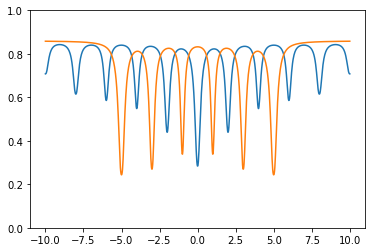

In [25]:

v = np.linspace(-10,10,1000)    


source = CobaltFe ()

absorber = alphaFe()
absorber.thickness_m = 3000e-9
absorber.abundance = 1
absorber.update_params()

moss_Fe_Fe = Mossbauer(source, absorber)

source = CobaltRhodium()
absorber = alphaFe()
absorber.thickness_m = 3000e-9
absorber.abundance = 1
absorber.update_params()

moss_Rh_Fe = Mossbauer(source, absorber)
norm = moss.source.mossbauer_photon_rate

plt.plot(v, moss_Fe_Fe.total_transmission_rate1(v)/norm, label = 'Fe')
plt.plot(v, moss_Rh_Fe.total_transmission_rate1(v)/norm, label = 'Rh')

plt.ylim(0,1)

In [132]:
1/np.exp(1)

0.36787944117144233

In [ ]:
# Scipy integration

from scipy.integrate import quad
def integrand(x, a, b):
    return a*x**2 + b
a = 2
b = 1
I = quad(integrand, 0, 1, args=(a,b))
I

In [ ]:
# Fractional Absorption vs mean-free-paths

t_mfp = np.linspace(0,8,100)
#epsilon = 1-np.exp(-t/2)*jv(0,1j*t/2).real
plt.plot(t_mfp,1-np.exp(-t_mfp/2))
plt.plot(t_mfp,t_mfp/2)
plt.plot(t_mfp,epsilon(t_mfp))
plt.ylim(0,1)